## Recommender Systems

Source and inspiration: https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson4.ipynb

In [131]:
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import torch.optim as optim
from collections import defaultdict
import torch.distributions as distributions
import pandas as pd
from collections import Counter
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

In [3]:
movie_data = pd.read_csv("../small_data/movie_data.tsv", sep='\t', names=['user', 'item', 'rating', 'timestamp'])
movie_data.head()

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
movie_info = pd.read_csv("../small_data/u.item", sep="|", encoding="latin-1", header=None)
movie_info.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
movie_name_dict = movie_info.set_index(0)[1].to_dict()

In [25]:
user_to_index = {u:i for i, u in enumerate(movie_data.user.unique())}
item_to_index = {u:i for i, u in enumerate(movie_data.item.unique())}

In [314]:
class CollaborativeFiltering(nn.Module):
    def __init__(self, user_size, item_size, embedding_dim):
        super(CollaborativeFiltering, self).__init__()
        
        self.user_embedding = nn.Embedding(user_size, embedding_dim)
        self.item_embedding = nn.Embedding(item_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim*2, embedding_dim)  # bias is True by default
        self.linear2 = nn.Linear(embedding_dim, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, user, item):
        user_embeds = self.user_embedding(user)
        item_embeds = self.item_embedding(item)
        drop_cat = self.dropout(torch.cat([user_embeds, item_embeds], 2))
        first_layer = self.relu(self.linear1(drop_cat))
        return self.linear2(self.dropout(first_layer))
    
    def get_user_emdedding(self, user):
        user_variable = Variable(torch.LongTensor([user_to_index[user]]))
        return self.user_embedding(user_variable).view(1,-1)
    
    def get_item_emdedding(self, item):
        item_variable = Variable(torch.LongTensor([item_to_index[item]]))
        return self.item_embedding(item_variable).view(1,-1)

In [315]:
training_fraction = 0.8
data = movie_data[['user', 'item', 'rating']].values
training_cutoff = int(data.shape[0] * training_fraction)
training_data = data[:training_cutoff]
testing_data = data[training_cutoff:]

In [316]:
cf = CollaborativeFiltering(len(user_to_index), len(item_to_index), 300)
criterion = nn.MSELoss()
optimizer = optim.Adam(cf.parameters(), lr = 0.001)

In [317]:
def get_variable(value):
    tensor = torch.LongTensor([value])
    return Variable(tensor)

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train(user, item, rating):
    cf.zero_grad()
    predicted_rating = cf.forward(user, item)
    loss = criterion(predicted_rating, rating)
    loss.backward()
    optimizer.step()
    return loss.data

In [318]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        row = self.data[index]
        return (torch.LongTensor([user_to_index[row[0]]]), 
                torch.LongTensor([item_to_index[row[1]]]), 
                torch.FloatTensor([int(row[2])]))
        
    def __len__(self):
        return len(self.data)

batch_size = 8
training_dataset = CustomDataset(training_data)
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

In [319]:
n_epochs = 1
print_every_batch = int(5000/batch_size)
plot_every_batch = int(500/batch_size)
all_losses = []
total_loss = 0 # Reset every plot_every iters
iter = 0

start = time.time()

for epoch in range(1, n_epochs + 1):
    for i_batch, sample_batched in enumerate(training_dataloader):
        loss = train(Variable(sample_batched[0]), Variable(sample_batched[1]), Variable(sample_batched[2]))
        total_loss += loss

        if iter % (print_every_batch*batch_size) == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / (len(data) * n_epochs) * 100, loss))

        if iter % (plot_every_batch*batch_size) == 0 and iter != 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0
        
        iter = iter + batch_size

0m 0s (0 0%) 16.8858
0m 6s (5000 10%) 0.9845
0m 14s (10000 20%) 2.3720
0m 26s (15000 30%) 0.7714
0m 40s (20000 40%) 1.7444
0m 55s (25000 50%) 1.9744
1m 11s (30000 60%) 0.9888
1m 27s (35000 70%) 1.5549


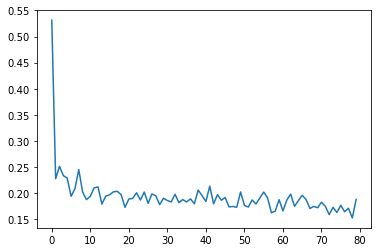

In [320]:
plt.plot(all_losses)

In [337]:
item_keys = list(item_to_index.keys())
item_features = np.array([cf.get_item_emdedding(i).data.numpy()[0] for i in item_keys])

In [338]:
item_features.shape

(1590, 300)

In [340]:
from sklearn.cluster import KMeans

In [359]:
clf = KMeans(n_clusters=15)
clf.fit(item_features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [360]:
zero_cluster_indexes = [i for i, l in enumerate(clf.labels_) if l==0]

In [361]:
[movie_name_dict[item_keys[i]] for i in zero_cluster_indexes]

['Sabrina (1995)',
 'Toy Story (1995)',
 "Mr. Holland's Opus (1995)",
 '2001: A Space Odyssey (1968)',
 'Ninotchka (1939)',
 'Cape Fear (1991)',
 'Angels in the Outfield (1994)',
 'Back to the Future (1985)',
 'Once Upon a Time in America (1984)',
 'Graduate, The (1967)',
 'Absolute Power (1997)',
 'Lost Horizon (1937)',
 'Psycho (1960)',
 'Great Expectations (1998)',
 'Rising Sun (1993)',
 'Beauty and the Beast (1991)',
 'Prophecy, The (1995)',
 'Carrie (1976)',
 'Dirty Dancing (1987)',
 'Being There (1979)',
 'Wedding Singer, The (1998)',
 'Rumble in the Bronx (1995)',
 'Glory (1989)',
 'Pillow Book, The (1995)',
 'Ma vie en rose (My Life in Pink) (1997)',
 'Fierce Creatures (1997)',
 'Killing Fields, The (1984)',
 "Smilla's Sense of Snow (1997)",
 'Convent, The (Convento, O) (1995)',
 'In the Line of Fire (1993)',
 'Jaws 3-D (1983)',
 'Hellraiser: Bloodline (1996)',
 'Primary Colors (1998)',
 'Walking and Talking (1996)',
 'Stars Fell on Henrietta, The (1995)',
 'Mrs. Parker and the

## how to get users rating for a movie?